In [168]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

data_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data_folder"))
sys.path.append(data_folder_path) 

from synth_dim_model import *
from paraparticle_utils import *

import numpy as np
import scipy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import concurrent.futures
plt.rcParams.update({'font.size': 12})

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x0000024764DEB5B0> at 0x000002470A1E5600>

In [169]:
def construct_single_site_number_operator(N, M, site_index, synth_level, states):
    dim = M**N
    number_operator_matrix = np.zeros((dim, dim), dtype=np.complex128)
    
    for k in range(dim):
        if states[k][site_index] == synth_level:
            number_operator_matrix[k,k] = 1
             
    return number_operator_matrix

def build_paraparticle_operator(N, site_index, alpha, sign):
    """
    Build paraparticle creation/annihilation operator at site_index (0-based).
    site_index ∈ [0, N-1]
    alpha ∈ {1, 2}
    sign ∈ {'+', '-'}
    """
    assert 0 <= site_index < N
    assert alpha in [1, 2]
    assert sign in ['+', '-']

    total_op = np.zeros((3**N, 3**N))

    # Generate all beta chains of length site_index (since 0-based)
    for beta_chain in product([1, 2], repeat=site_index):
        op_list = []

        # Construct the x^{(sign)}_{i,beta_{i-1}} part
        beta_prev = beta_chain[-1] if beta_chain else alpha
        x_op = x_matrices[(sign, beta_prev)]
        op_list.append(x_op)

        # Build T^{(sign)} chain in reverse site order
        for k in reversed(range(site_index)):
            beta_k = beta_chain[k]
            beta_k_minus_1 = alpha if k == 0 else beta_chain[k - 1]
            T_k = T_matrices[(sign, beta_k_minus_1, beta_k)]
            op_list.insert(0, T_k)  # prepend

        # Pad identity operators
        full_op_list = (
            [id3] * (site_index - len(op_list))  # left padding
            + op_list
            + [id3] * (N - site_index - 1)       # right padding
        )

        # Compute full Kronecker product
        kron_op = full_op_list[0]
        for m in range(1, len(full_op_list)):
            kron_op = np.kron(kron_op, full_op_list[m])

        total_op += kron_op

    return total_op

def construct_site_paraparticle_number_operator(N, site_index):
    """
    Construct the total paraparticle number operator at a given site (0-based indexing).

    site_index ∈ [0, N-1]
    """
    assert 0 <= site_index < N

    n_i = np.zeros((3**N, 3**N), dtype=complex)

    for alpha in [1, 2]:
        psi_plus = build_paraparticle_operator(N, site_index, alpha, '+')
        psi_minus = build_paraparticle_operator(N, site_index, alpha, '-')
        n_i += psi_plus @ psi_minus

    return n_i


In [170]:
N = 6
M = 3
V = 1

states, formatted_states = enumerate_states(N, M) 

H = construct_hamiltonian(N, M, V = 1, mu = 0, J = 0)
eigenvalues, eigenvectors = exact_diagonalize(H)
ground_state_manifold = construct_ground_state_manifold(eigenvalues, eigenvectors)

number_op = construct_total_paraparticle_number_operator(N)

for i, state in enumerate(eigenvectors):
    if state.conj().T @ number_op @ state == 0j:
        print(f"state {i} has zero paraparticles")
        paraparticle_vacuum = state

state 329 has zero paraparticles


In [171]:
psi1 = build_paraparticle_operator(N, site_index = N-1, alpha = 2, sign = "+") @ build_paraparticle_operator(N, site_index = 0, alpha = 1, sign = "+") @ paraparticle_vacuum

for i in range(N):
    print(i)
    op = construct_site_paraparticle_number_operator(N, site_index = i)
    print(psi1.conj().T @ op @ psi1)
    print()

0
(1+0j)

1
0j

2
0j

3
0j

4
0j

5
(1+0j)



In [172]:
def construct_single_site_number_operator(N, M, site_index, synth_level, states):
    dim = M**N
    number_operator_matrix = np.zeros((dim, dim), dtype=np.complex128)
    
    for k in range(dim):
        if states[k][site_index] == synth_level:
            number_operator_matrix[k,k] = 1
             
    return number_operator_matrix

In [173]:
# alpha = 1 -> spin up
# alpha = 2 -> spin down

In [174]:
times = np.linspace(0,10,100)
H = construct_hamiltonian(N, M, V = 1, mu = 0, J = 0)

site_dep_averages_up = []
site_dep_averages_down = []
for site_index in range(N):
    up_averages = []
    down_averages = []
    for time in times:
        exp_values = []

        n_i_up = construct_single_site_number_operator(N, M = 3, site_index = site_index, synth_level = 2, states = states)
        time_dep_n_i_up = scipy.linalg.expm(1j*time*H) @ n_i_up @ scipy.linalg.expm(-1j*time*H)
        
        n_i_down = construct_single_site_number_operator(N, M = 3, site_index = site_index, synth_level = 0, states = states)
        time_dep_n_i_down = scipy.linalg.expm(1j*time*H) @ n_i_down @ scipy.linalg.expm(-1j*time*H)
        
        up_exps = []
        down_exps = []
        
        for ground_state in ground_state_manifold:
            psi = build_paraparticle_operator(N, site_index = N-1, alpha = 2, sign = "+") @ build_paraparticle_operator(N, site_index = 0, alpha = 1, sign = "+") @ ground_state
            psi = psi/np.linalg.norm(psi)
            
            n_i_t_exp_value_up = np.real(psi.conj().T @ time_dep_n_i_up @ psi)
            n_i_t_exp_value_down = np.real(psi.conj().T @ time_dep_n_i_down @ psi)
            
            up_exps.append(n_i_t_exp_value_up)
            down_exps.append(n_i_t_exp_value_down)
        
        up_averages.append(np.mean(up_exps))
        down_averages.append(np.mean(down_exps))
    
    site_dep_averages_up.append(up_averages)
    site_dep_averages_down.append(down_averages)
    
    

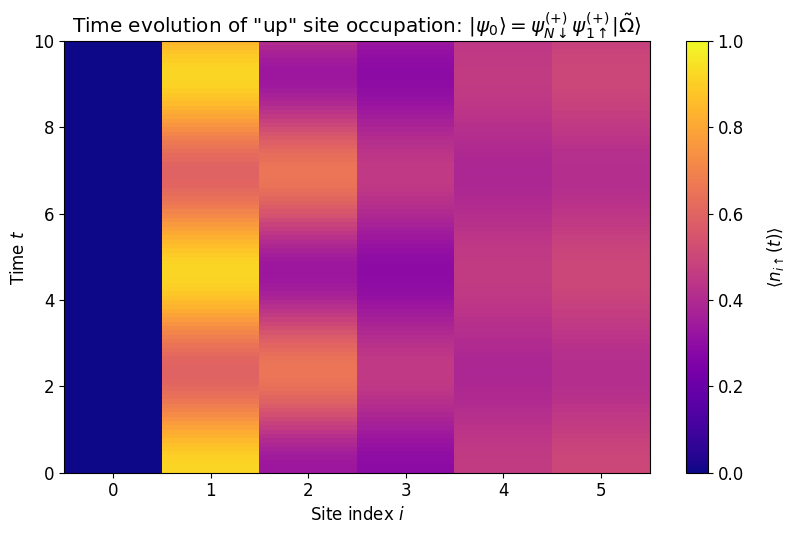

In [175]:
up_data = np.array(site_dep_averages_up)
up_data = np.real_if_close(up_data)

fig, ax = plt.subplots(figsize=(8.25, 5.5))

# Define grid edges
x_edges = np.arange(N + 1)          # 0, 1, ..., N
y_edges = np.linspace(times[0], times[-1], len(times) + 1)

# Use pcolormesh with edges
pcm = ax.pcolormesh(x_edges, y_edges, up_data.T, shading='auto', cmap='plasma', vmin = 0, vmax = 1)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r'$\langle n_{i\uparrow}(t) \rangle$', rotation=90, labelpad=15)

# Center ticks
ax.set_xticks(np.arange(N) + 0.5)
ax.set_xticklabels([str(i) for i in range(N)])

ax.set_xlabel('Site index $i$')
ax.set_ylabel('Time $t$')
ax.set_title(r'Time evolution of "up" site occupation: $|\psi_0 \rangle = \psi^{(+)}_{N\downarrow}  \psi^{(+)}_{1\uparrow} |\tilde{\Omega} \rangle$')
fig.tight_layout()
plt.show()


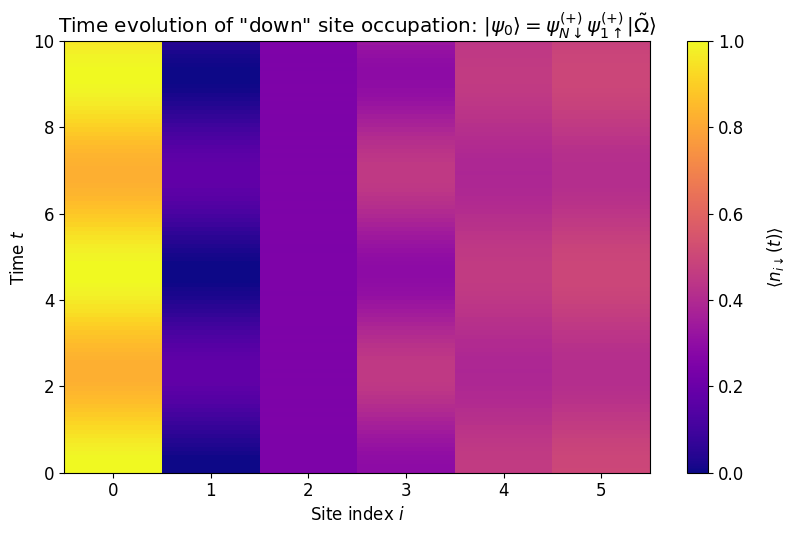

In [176]:
down_data = np.array(site_dep_averages_down)
down_data = np.real_if_close(down_data)

fig, ax = plt.subplots(figsize=(8.25, 5.5))

# Define grid edges
x_edges = np.arange(N + 1)          # 0, 1, ..., N
y_edges = np.linspace(times[0], times[-1], len(times) + 1)

# Use pcolormesh with edges
pcm = ax.pcolormesh(x_edges, y_edges, down_data.T, shading='auto', cmap='plasma', vmin = 0, vmax = 1)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r'$\langle n_{i\downarrow}(t) \rangle$', rotation=90, labelpad=15)

# Center ticks
ax.set_xticks(np.arange(N) + 0.5)
ax.set_xticklabels([str(i) for i in range(N)])

ax.set_xlabel('Site index $i$')
ax.set_ylabel('Time $t$')
ax.set_title(r'Time evolution of "down" site occupation: $|\psi_0 \rangle = \psi^{(+)}_{N\downarrow}  \psi^{(+)}_{1\uparrow} |\tilde{\Omega} \rangle$')
fig.tight_layout()
plt.show()


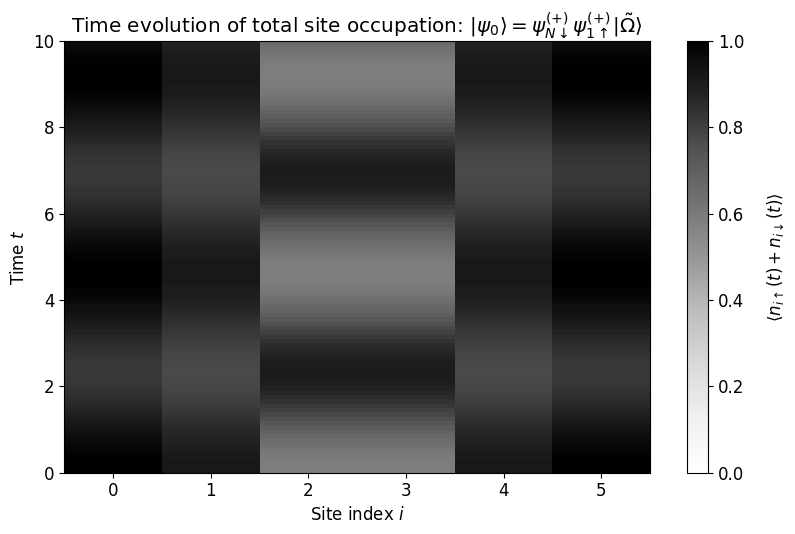

In [177]:
total_data = up_data + down_data

fig, ax = plt.subplots(figsize=(8.25, 5.5))

# Define grid edges
x_edges = np.arange(N + 1)          # 0, 1, ..., N
y_edges = np.linspace(times[0], times[-1], len(times) + 1)

# Use pcolormesh with edges
pcm = ax.pcolormesh(x_edges, y_edges, total_data.T, shading='auto', cmap='Greys', vmin = 0, vmax = 1)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r'$\langle n_{i\uparrow}(t) + n_{i\downarrow}(t) \rangle$', rotation=90, labelpad=15)

# Center ticks
ax.set_xticks(np.arange(N) + 0.5)
ax.set_xticklabels([str(i) for i in range(N)])

ax.set_xlabel('Site index $i$')
ax.set_ylabel('Time $t$')
ax.set_title(r'Time evolution of total site occupation: $|\psi_0 \rangle = \psi^{(+)}_{N\downarrow}  \psi^{(+)}_{1\uparrow} |\tilde{\Omega} \rangle$')
fig.tight_layout()
plt.show()


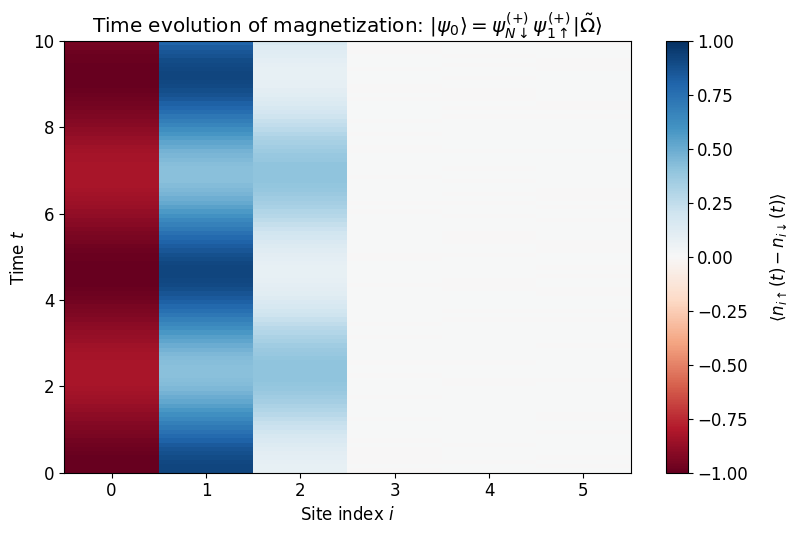

In [178]:
mag_data = up_data - down_data

fig, ax = plt.subplots(figsize=(8.25, 5.5))

# Define grid edges
x_edges = np.arange(N + 1)          # 0, 1, ..., N
y_edges = np.linspace(times[0], times[-1], len(times) + 1)

# Use pcolormesh with edges
pcm = ax.pcolormesh(x_edges, y_edges, mag_data.T, shading='auto', cmap='RdBu', vmin = -1, vmax = 1)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r'$\langle n_{i\uparrow}(t) - n_{i\downarrow}(t) \rangle$', rotation=90, labelpad=15)

# Center ticks
ax.set_xticks(np.arange(N) + 0.5)
ax.set_xticklabels([str(i) for i in range(N)])

ax.set_xlabel('Site index $i$')
ax.set_ylabel('Time $t$')
ax.set_title(r'Time evolution of magnetization: $|\psi_0 \rangle = \psi^{(+)}_{N\downarrow}  \psi^{(+)}_{1\uparrow} |\tilde{\Omega} \rangle$')
fig.tight_layout()
plt.show()
